# Visualização e pré-processamento

A seguir, a implementação de cada um dos filtros: passa-faixa (bandpass), passa-baixa (lowpass), passa-alta (highpass) e corta-faixa (notch).

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import warnings
from matplotlib import rcParams
import numpy as np
from scipy import signal
from sklearn.preprocessing import LabelEncoder
import mne

# definições de filtros

def butter_bandpass(data, lowcut, highcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='bandpass')
    return signal.filtfilt(b, a, data)


def butter_lowpass(data, lowcut, fs=512, order=4):
    nyq = fs * 0.5
    low = lowcut / nyq
    b, a = signal.butter(order, low, btype='lowpass')
    return signal.filtfilt(b, a, data)


def butter_highpass(data, highcut, fs=512, order=4):
    nyq = fs * 0.5
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='highpass')
    return signal.filtfilt(b, a, data)


def butter_notch(data, cutoff, var=1, fs=512, order=4):
    nyq = fs * 0.5
    low = (cutoff - var) / nyq
    high = (cutoff + var) / nyq
    b, a = signal.iirfilter(order, [low, high], btype='bandstop', ftype="butter")
    return signal.filtfilt(b, a, data)

Para imprimir os dados no domínio da frequência, foi utilizado a função matplotlib.pyplot.psd que na verdade utiliza a transformação dos dados por FFT, porém aplica uma característica que evidencia a "energia" dos dados, chamado de PSD (Power Spectrum Density)

Definição de função para imprimir os dados no domínio do tempo e da frequência

In [2]:
def print_graphs(data):
    for i in range(0, 21, 3):
        plt.plot(data[i,:])
    plt.title('Domínio do tempo')
    plt.show()

    for i in range(0, 21, 3):
        plt.psd(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

    for i in range(0, 21, 3):
        plt.specgram(data[i,:], Fs=512)
    plt.title('Domínio da frequência')
    plt.show()

Carregamento dos dados de um participante da base de dados AVI:

In [3]:
data = np.load("../../../datasets/avi/single/data.npy")
print(data.shape)

# Transpondo dados para organizar os dados na última dimensão
data = data.swapaxes(2, 1)
data = data.reshape(data.shape[0] * data.shape[1], data.shape[2])
print(data.shape)

(4, 15360, 21)
(84, 15360)


Visualização do sinal em todos os domínios apresentados, sem a aplicação de nenhum filtro:

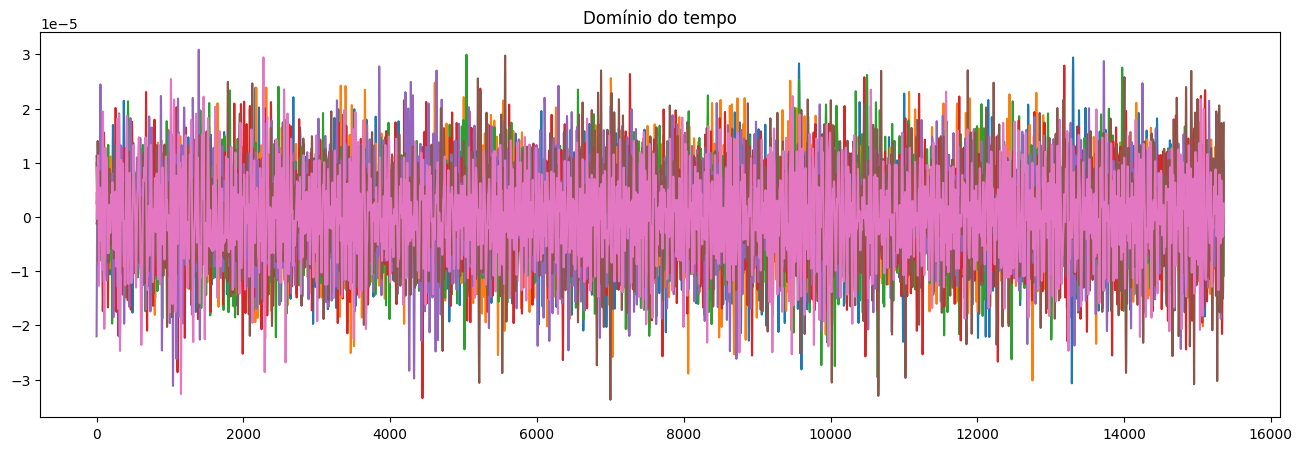

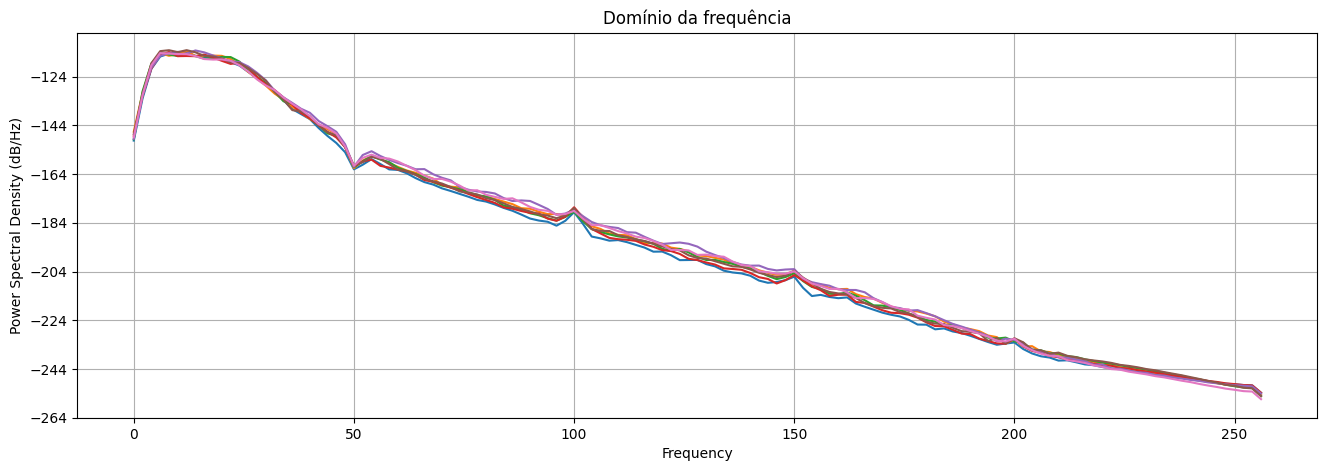

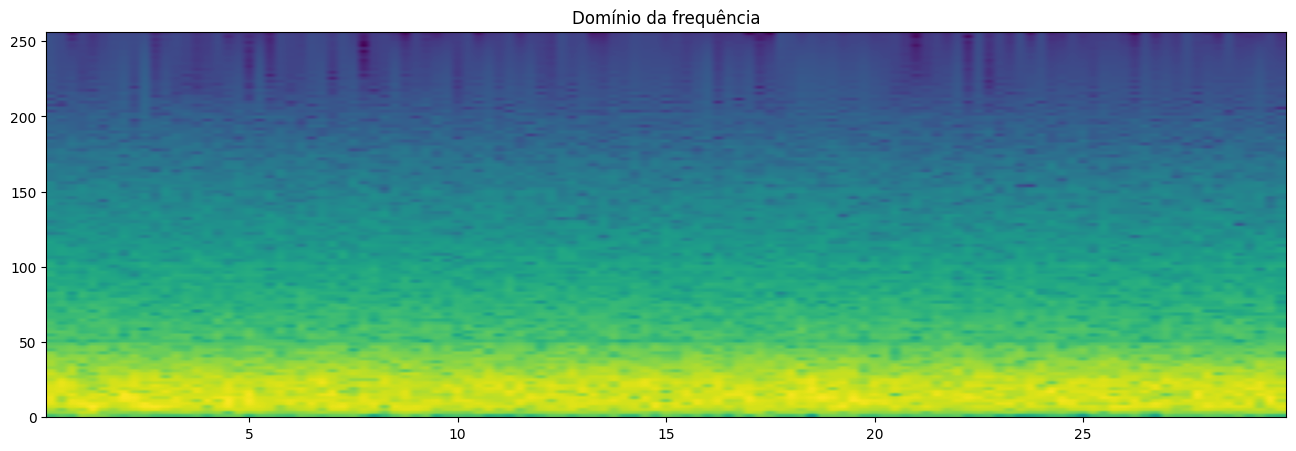

In [4]:
rcParams['figure.figsize'] = [16., 5.]
print_graphs(data)

Para facilitar o trabalho de visualização dos dados nas faixas de frequência de trabalho, vamos utilizar a ferramenta MNE:

In [5]:
# criação de um objeto "info"
n_channels = 1
sfreq = 512
ch_names = ['Oz']
ch_types = ['eeg']
info = mne.create_info(ch_names, sfreq=sfreq, ch_types=ch_types)
info

<Info | 7 non-empty values
 bads: []
 ch_names: Oz
 chs: 1 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: unspecified
 nchan: 1
 projs: []
 sfreq: 512.0 Hz
>

In [6]:
from sklearn.preprocessing import LabelEncoder

# adicionando label como "épocas" do sinal
labels = np.load("../../../datasets/avi/single/labels.npy")
labels = labels.reshape(labels.shape[0] * labels.shape[1] * labels.shape[2])
print(labels, labels.shape)

# método para transformar labels categóricos
le = LabelEncoder()
events = np.column_stack((
    np.array(range(len(labels))),
    np.zeros(labels.shape[0], dtype=int),
    le.fit_transform(labels))
)
print(events)

# data : array, shape (n_epochs, n_channels, n_times)
data_correct = data.reshape(data.shape[0], 1, data.shape[1])
print(data_correct.shape)

event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}
mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
mne_data

[10.  10.  10.   6.5  6.5  6.5  6.   6.   6.   7.5  7.5  7.5  7.   7.
  7.   8.2  8.2  8.2  9.3  9.3  9.3 10.  10.  10.   6.5  6.5  6.5  6.
  6.   6.   7.5  7.5  7.5  7.   7.   7.   8.2  8.2  8.2  9.3  9.3  9.3
 10.  10.  10.   6.5  6.5  6.5  6.   6.   6.   7.5  7.5  7.5  7.   7.
  7.   8.2  8.2  8.2  9.3  9.3  9.3 10.  10.  10.   6.5  6.5  6.5  6.
  6.   6.   7.5  7.5  7.5  7.   7.   7.   8.2  8.2  8.2  9.3  9.3  9.3] (84,)
[[ 0  0  6]
 [ 1  0  6]
 [ 2  0  6]
 [ 3  0  1]
 [ 4  0  1]
 [ 5  0  1]
 [ 6  0  0]
 [ 7  0  0]
 [ 8  0  0]
 [ 9  0  3]
 [10  0  3]
 [11  0  3]
 [12  0  2]
 [13  0  2]
 [14  0  2]
 [15  0  4]
 [16  0  4]
 [17  0  4]
 [18  0  5]
 [19  0  5]
 [20  0  5]
 [21  0  6]
 [22  0  6]
 [23  0  6]
 [24  0  1]
 [25  0  1]
 [26  0  1]
 [27  0  0]
 [28  0  0]
 [29  0  0]
 [30  0  3]
 [31  0  3]
 [32  0  3]
 [33  0  2]
 [34  0  2]
 [35  0  2]
 [36  0  4]
 [37  0  4]
 [38  0  4]
 [39  0  5]
 [40  0  5]
 [41  0  5]
 [42  0  6]
 [43  0  6]
 [44  0  6]
 [45  0  1]
 [46  0  1]
 [47  0

Number of events,84
Events,10: 126: 126.5: 127: 127.5: 128.2: 129.3: 12
Time range,0.000 – 29.998 s
Baseline,off


Need more than one channel to make topography for eeg. Disabling interactivity.



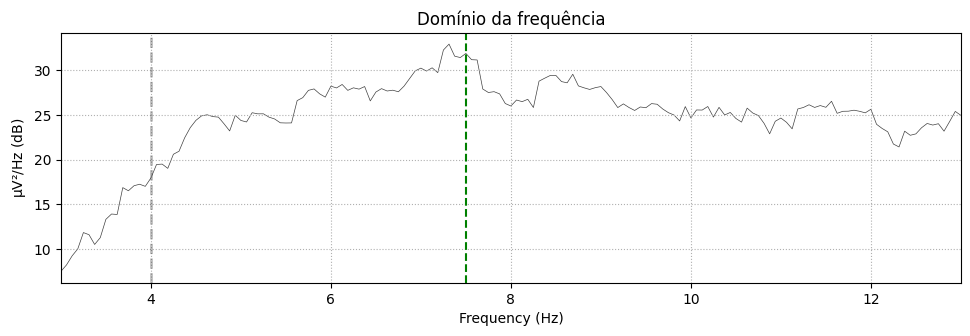

Need more than one channel to make topography for eeg. Disabling interactivity.



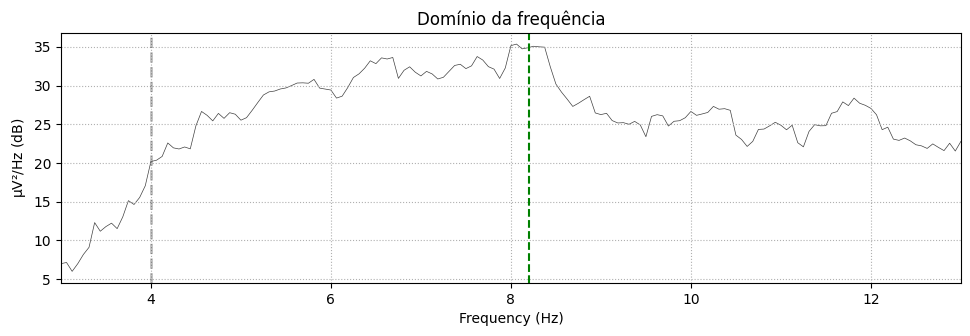

Need more than one channel to make topography for eeg. Disabling interactivity.



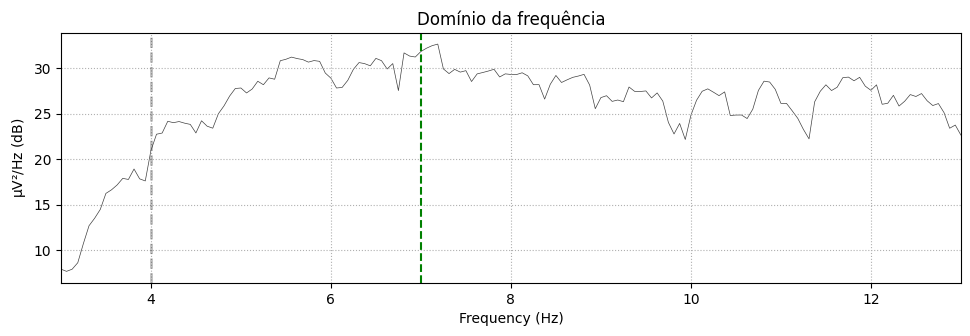

Need more than one channel to make topography for eeg. Disabling interactivity.



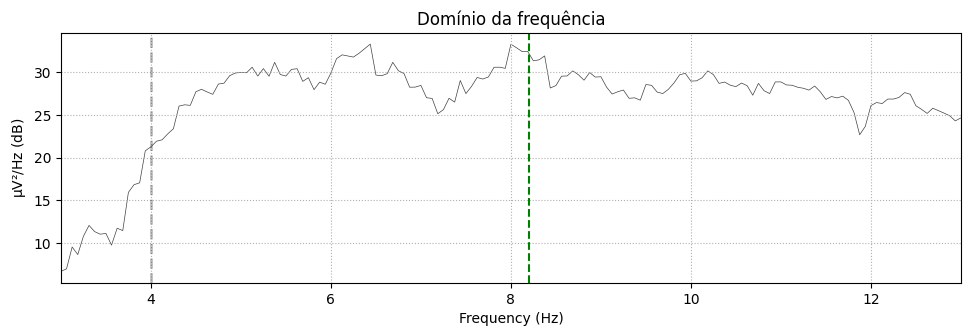

Need more than one channel to make topography for eeg. Disabling interactivity.



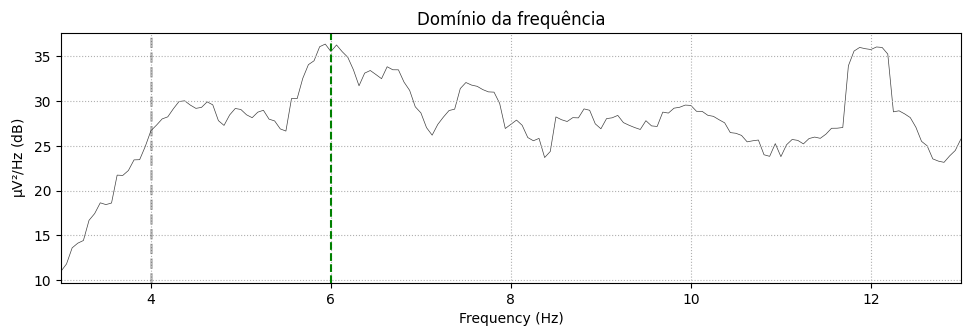

Need more than one channel to make topography for eeg. Disabling interactivity.



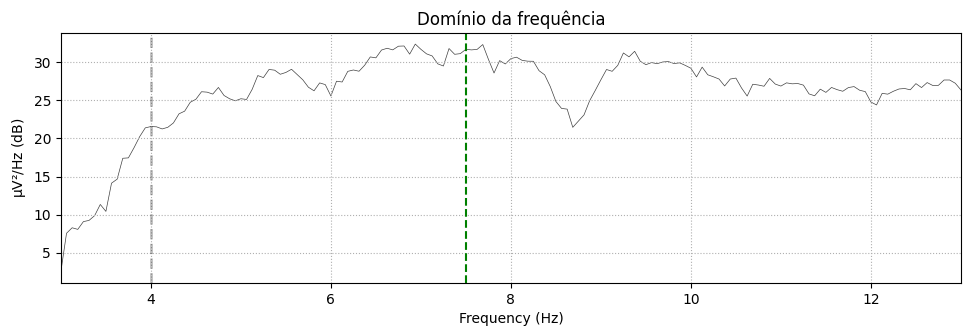

Need more than one channel to make topography for eeg. Disabling interactivity.



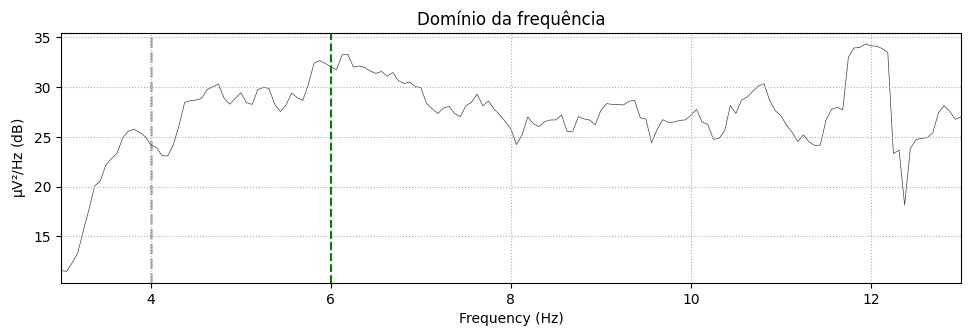

Need more than one channel to make topography for eeg. Disabling interactivity.



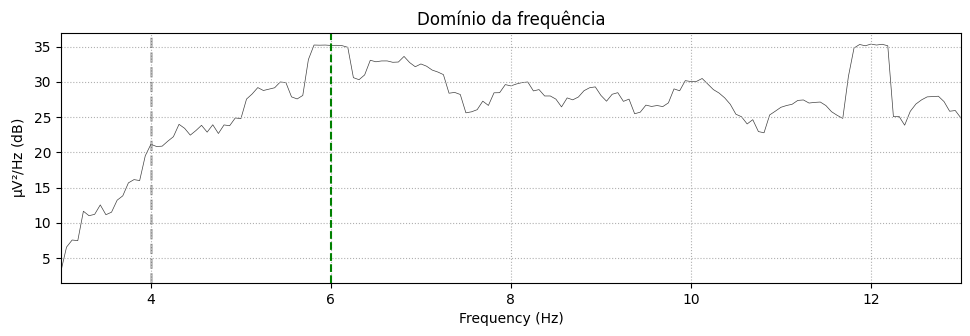

Need more than one channel to make topography for eeg. Disabling interactivity.



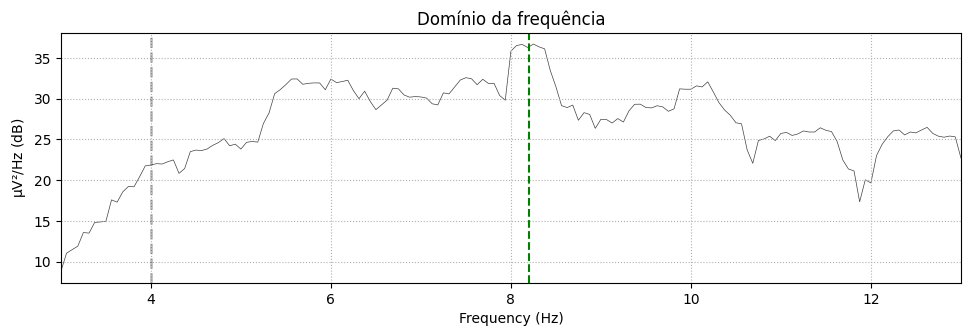

Need more than one channel to make topography for eeg. Disabling interactivity.



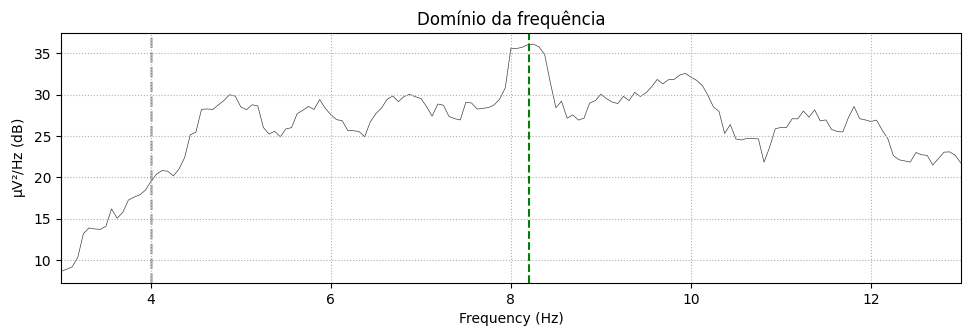

Need more than one channel to make topography for eeg. Disabling interactivity.



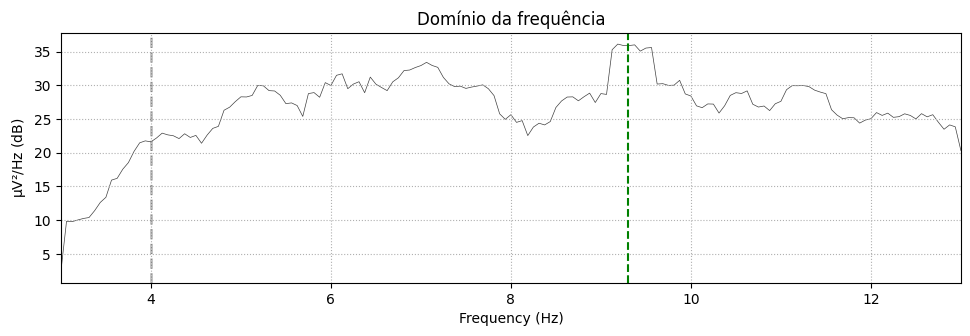

Need more than one channel to make topography for eeg. Disabling interactivity.



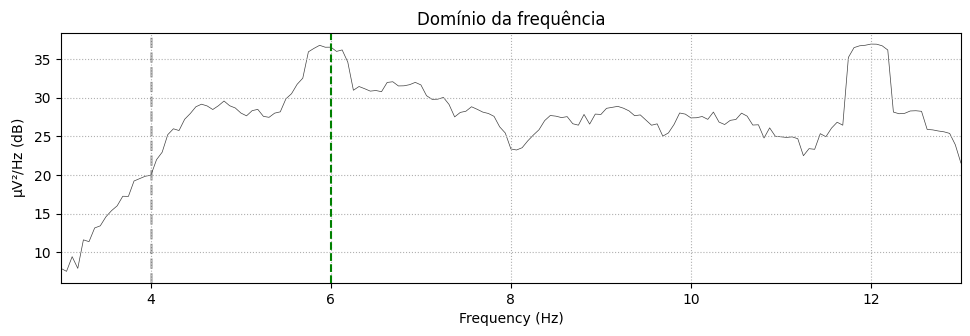

Need more than one channel to make topography for eeg. Disabling interactivity.



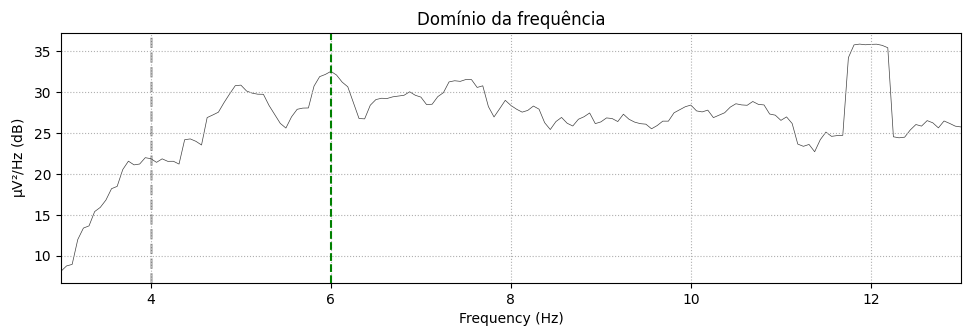

Need more than one channel to make topography for eeg. Disabling interactivity.



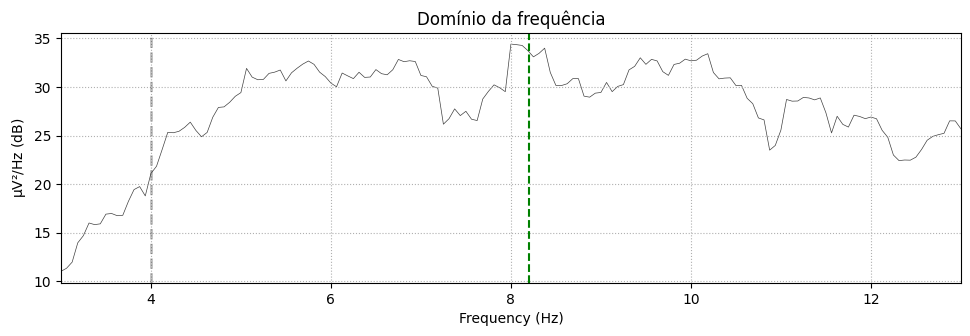

Need more than one channel to make topography for eeg. Disabling interactivity.



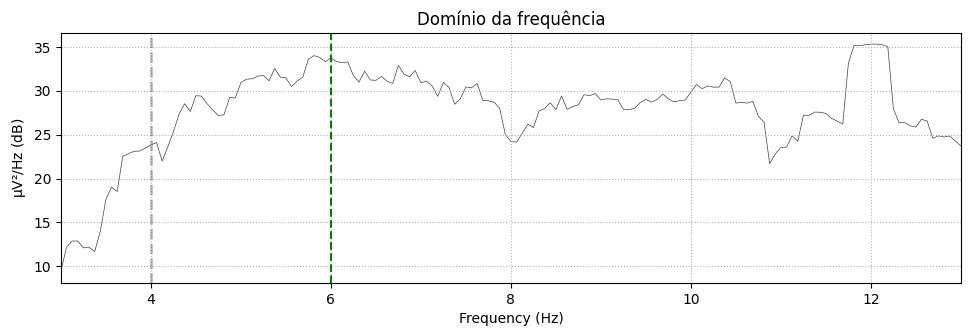

Need more than one channel to make topography for eeg. Disabling interactivity.



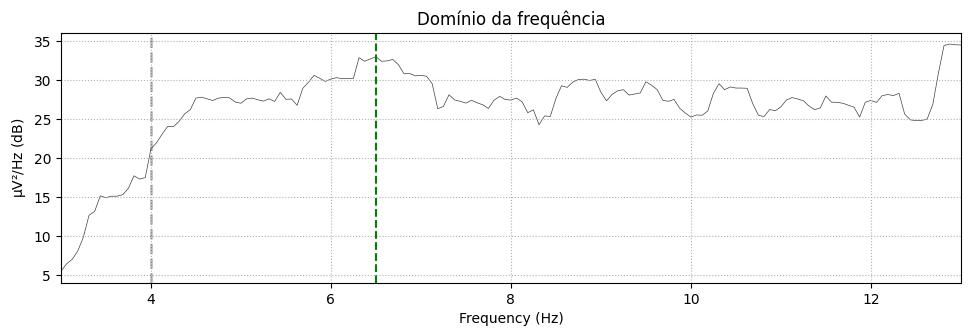

Need more than one channel to make topography for eeg. Disabling interactivity.



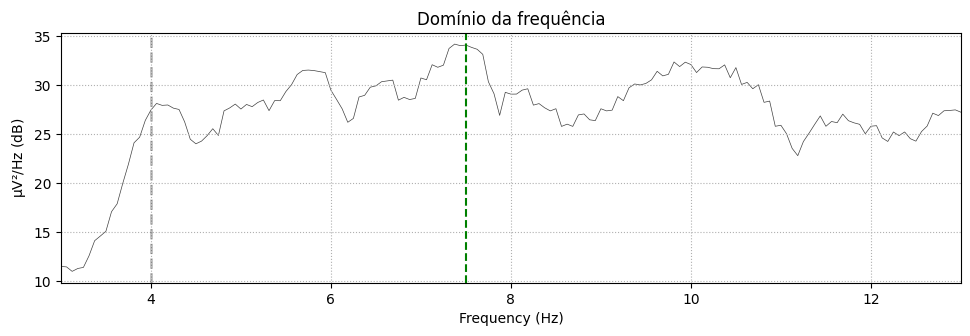

Need more than one channel to make topography for eeg. Disabling interactivity.



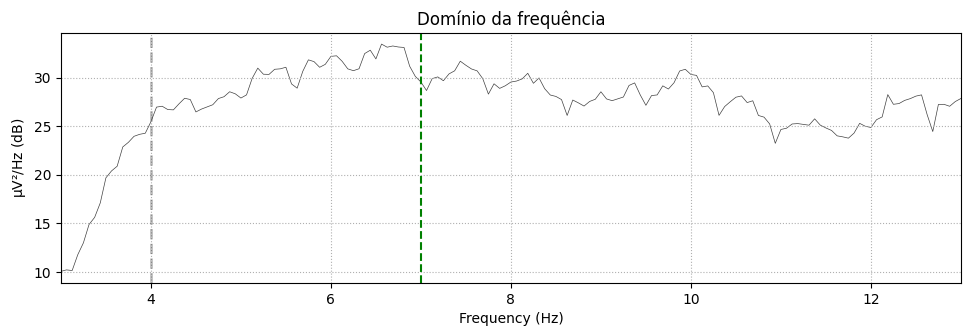

Need more than one channel to make topography for eeg. Disabling interactivity.



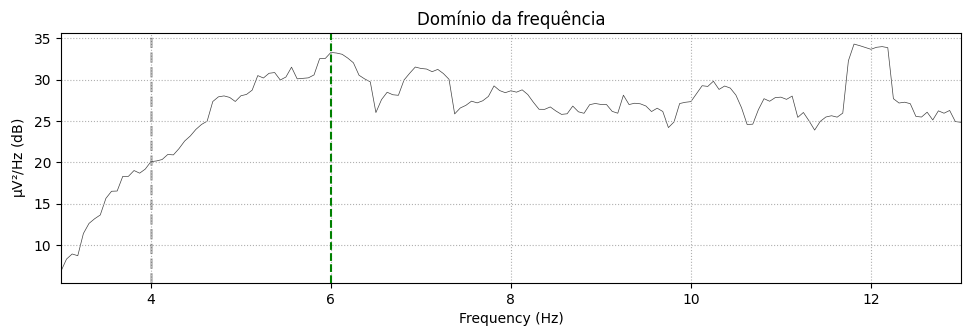

Need more than one channel to make topography for eeg. Disabling interactivity.



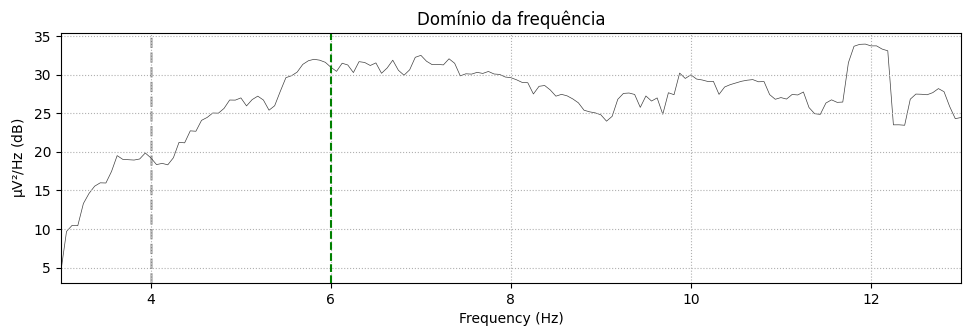

In [11]:
import warnings
warnings.filterwarnings('ignore')

# view = mne_data.compute_psd(method='welch', fmin=3, fmax=13)
for i in range(len(mne_data)):
    view = mne_data[i].compute_psd(method='multitaper', fmin=3, fmax=13, verbose=False)
    view.plot(show=False)
    print()
    plt.title('Domínio da frequência')
    plt.axvline(x=float(list(mne_data[i].event_id)[0]), linestyle='--', color='green')
    plt.show()
print()

In [12]:
# aplicando o filtro
mne_data_filtered = mne_data.filter(l_freq=4., h_freq=12., fir_design='firwin')

# salvando os dados
mne_data_filtered.save(fname="../../../datasets/avi/single/mne_data.fif", overwrite=True)

Setting up band-pass filter from 4 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 3.00 Hz (-6 dB cutoff frequency: 13.50 Hz)
- Filter length: 845 samples (1.650 s)

Overwriting existing file.


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Single Target

In [13]:
warnings.filterwarnings('ignore')

data = np.load("../../../datasets/avi/single/data.npy").swapaxes(1,2)
labels = np.load("../../../datasets/avi/single/labels.npy")
# print(data.shape, labels.shape)

event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5, '10':6}

for i, subject in enumerate(data):
    data_correct = subject.reshape(subject.shape[0], 1, subject.shape[1])
    labels_correct = labels[i].reshape(labels[i].shape[0] * labels[i].shape[1])
    # print(data_correct.shape, labels_correct.shape)

    events = np.column_stack((
        np.array(range(len(labels_correct))),
        np.zeros(labels_correct.shape[0], dtype=int),
        LabelEncoder().fit_transform(labels_correct)
    ))
    # print(events)

    mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
    mne_data.filter(l_freq=4., h_freq=14., fir_design='firwin')
    mne_data.save('../../../datasets/avi/single/filtered-sub-'+str(i)+'.fif', overwrite=True)

Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (1.650 s)

Overwriting existing file.
Not setting metadata
21 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


## Multi Target

In [14]:
warnings.filterwarnings('ignore')
data = np.load("../../../datasets/avi/multi/data.npy")
labels = np.load("../../../datasets/avi/multi/labels.npy")
print(data.shape, labels.shape)

event_dict = {'6':0, '6.5':1, '7':2, '7.5':3, '8.2':4, '9.3':5}

for i, subject in enumerate(data):
    data_correct = subject.reshape(subject.shape[0], 1, subject.shape[1])
    labels_correct = labels[i]
    # print(data_correct.shape, labels_correct.shape)
    
    events = np.column_stack((
        np.array(range(len(labels_correct))),
        np.zeros(labels_correct.shape[0], dtype=int),
        LabelEncoder().fit_transform(labels_correct)
    ))

    mne_data = mne.EpochsArray(data_correct, info, events, event_id=event_dict)
    mne_data.filter(l_freq=4., h_freq=14., fir_design='firwin')
    mne_data.save('../../../datasets/avi/multi/filtered-sub-'+str(i)+'.fif', overwrite=True)

(5, 20, 8192) (5, 20)
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 3.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 845 samples (1.650 s)

Overwriting existing file.
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated
Setting up band-pass filter from 4 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.01

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
